In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Read the processed data
processed_df = pd.read_parquet('../data/processed/rural/RFID_processed.parquet')
# sort processed_df by Time and reset index
processed_df = processed_df.sort_values(by='Time').reset_index(drop=True)

In [28]:
processed_df.head()

,Time,Location,Unit number,Transponder code,Period
0,2024-03-02 00:00:04,UNKNOWN,2.0,79FEADE,1.0
1,2024-03-02 00:00:05,orange_tunnel,7.0,79FEADE,1.0
2,2024-03-02 00:00:07,orange_cage,7.0,79FEADE,1.0
3,2024-03-02 00:00:07,orange_tunnel,2.0,79FEADE,1.0
4,2024-03-02 00:00:12,orange_tunnel,7.0,79FEADE,1.0


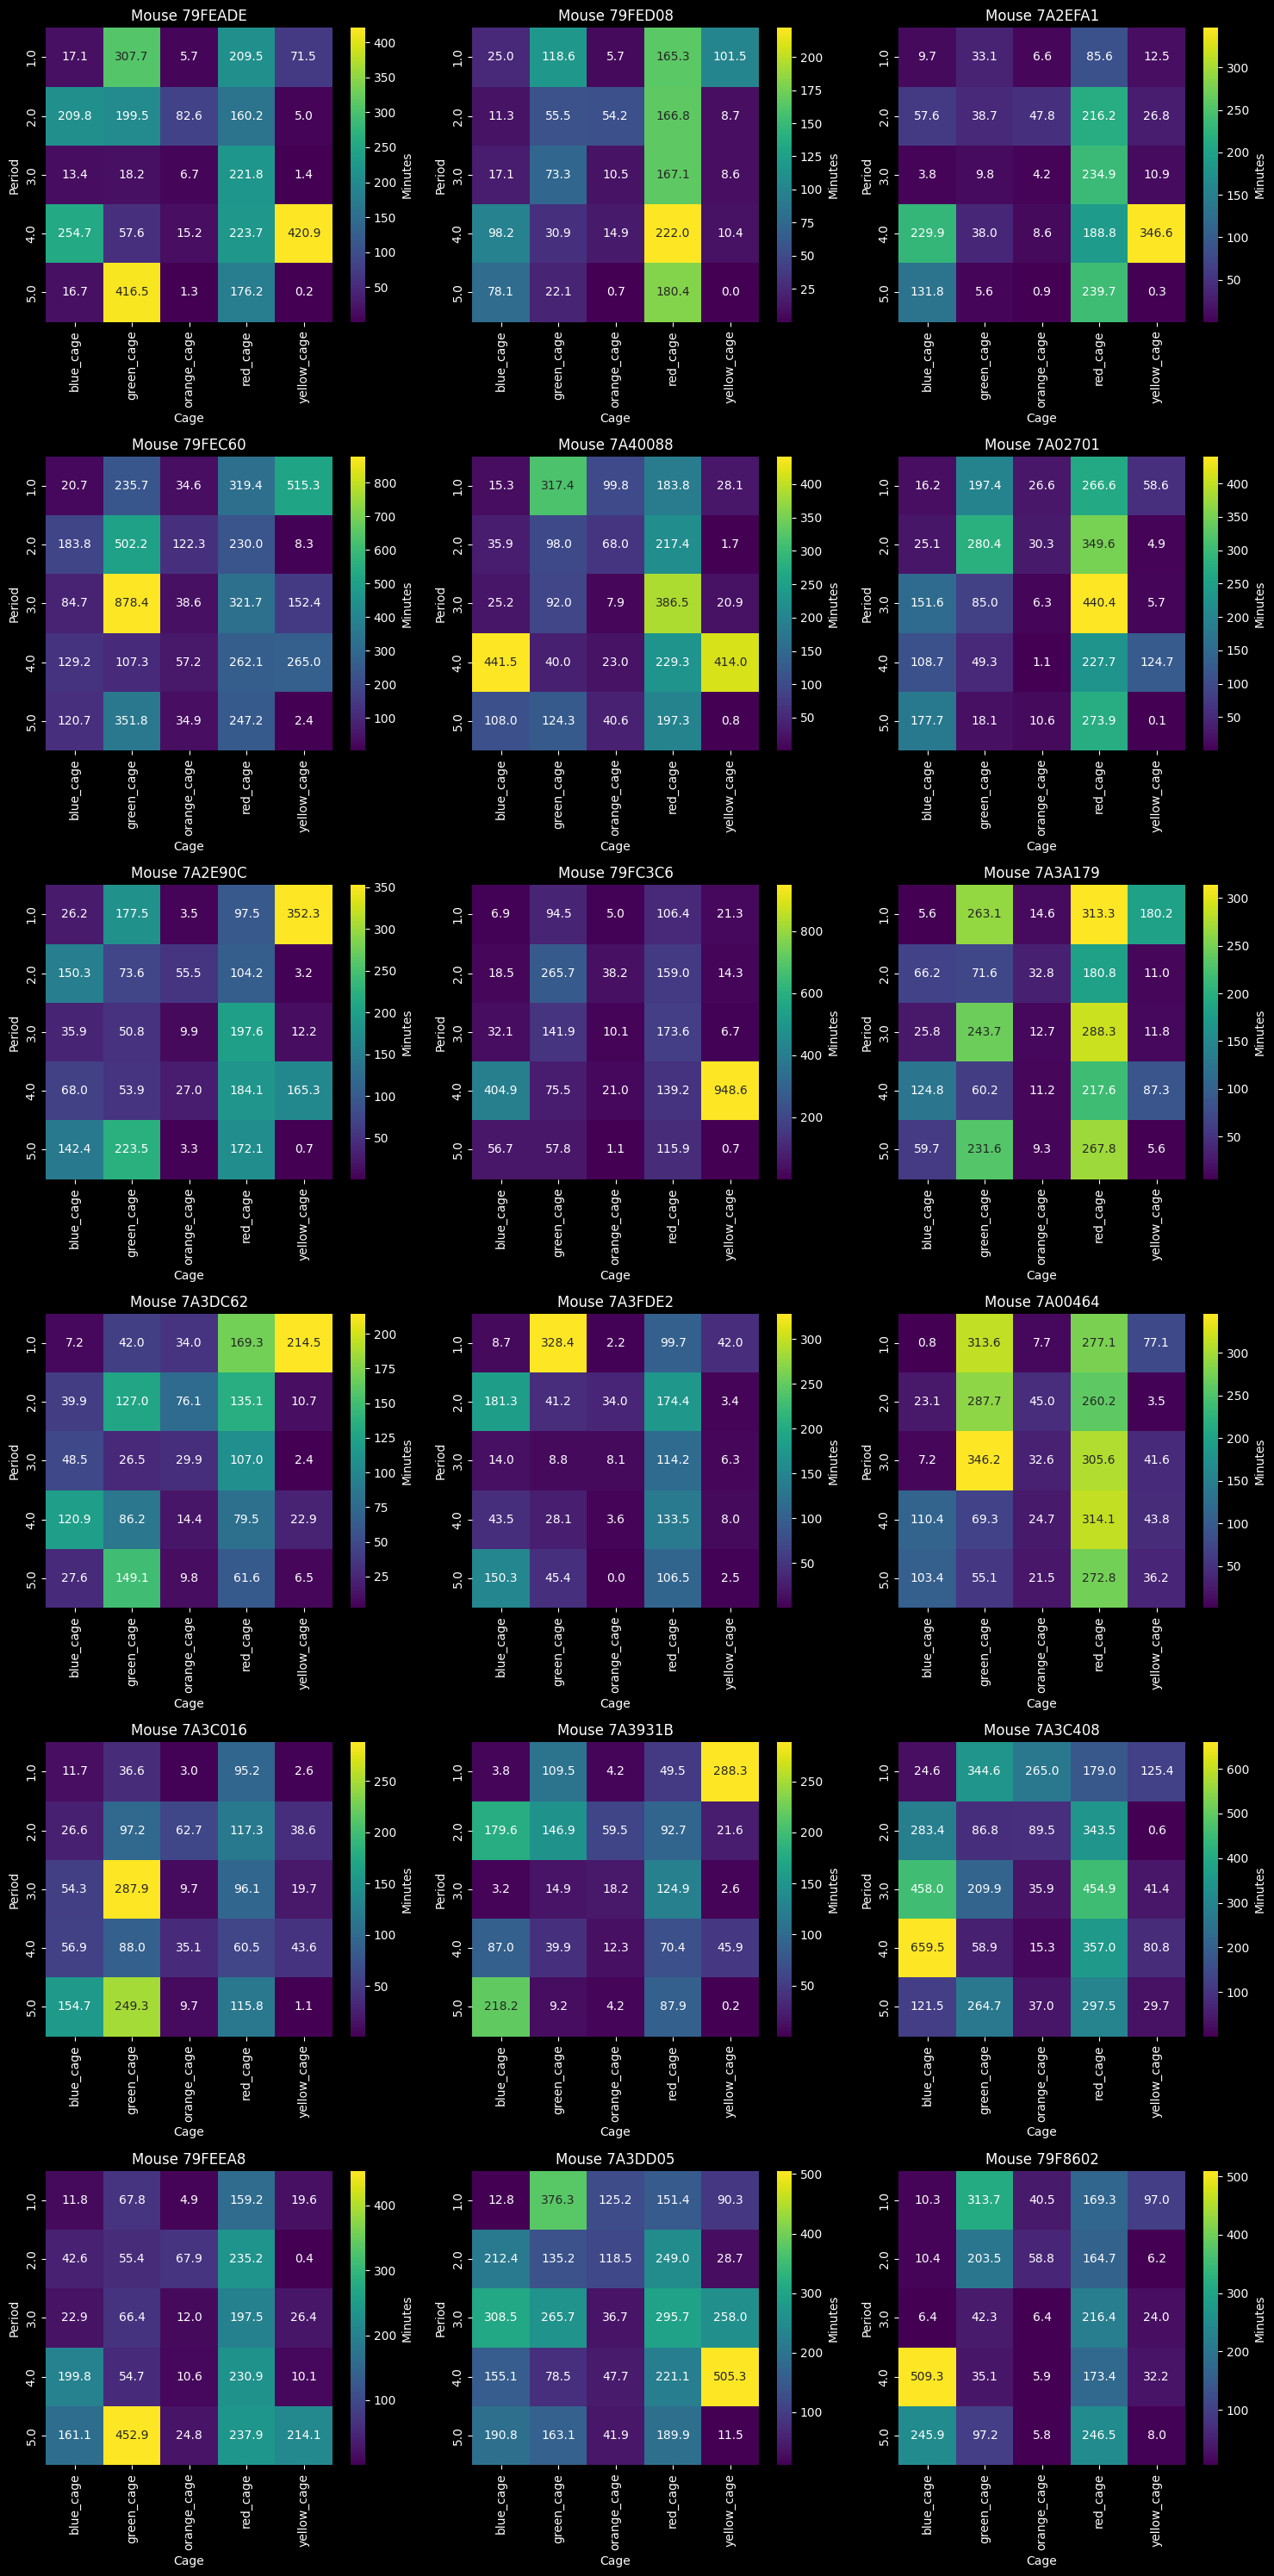

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get unique values
mice = processed_df['Transponder code'].unique()
cages = ['red_cage', 'orange_cage', 'yellow_cage', 'green_cage', 'blue_cage']
periods = sorted(processed_df['Period'].unique())

# Initialize results list
results = []

# Process each mouse and period
for mouse in mice:
    mouse_data = processed_df[processed_df['Transponder code'] == mouse]
    
    for period in periods:
        period_data = mouse_data[mouse_data['Period'] == period].copy()
        
        if len(period_data) > 1:  # Need at least 2 readings to calculate time
            # Create shifted columns to detect location changes
            period_data['Next_Location'] = period_data['Location'].shift(-1)
            period_data['Next_Time'] = period_data['Time'].shift(-1)
            
            for cage in cages:
                # Find where mouse entered the cage (next location is cage)
                cage_entries = period_data[
                    (period_data['Next_Location'] == cage)
                ]
                
                # Calculate total time
                if len(cage_entries) > 0:
                    time_diff = (cage_entries['Next_Time'] - cage_entries['Time'])
                    total_minutes = time_diff.dt.total_seconds().sum() / 60
                else:
                    total_minutes = 0
                
                results.append({
                    'Mouse': mouse,
                    'Period': period,
                    'Cage': cage,
                    'Time (min)': total_minutes
                })
        else:
            # Add zero entries if insufficient data
            for cage in cages:
                results.append({
                    'Mouse': mouse,
                    'Period': period,
                    'Cage': cage,
                    'Time (min)': 0
                })

# Create DataFrame and pivot for visualization
results_df = pd.DataFrame(results)

# Create heatmap grid
n_mice = len(mice)
n_cols = 3
n_rows = (n_mice + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
if n_rows == 1:
    axes = np.array([axes])
axes = axes.flatten()

for idx, mouse in enumerate(mice):
    mouse_data = results_df[results_df['Mouse'] == mouse]
    
    # Pivot data for heatmap
    pivot_data = mouse_data.pivot(index='Period', columns='Cage', values='Time (min)')
    
    # Create heatmap
    sns.heatmap(pivot_data, 
                ax=axes[idx],
                cmap='viridis',
                annot=True,
                fmt='.1f',
                cbar_kws={'label': 'Minutes'})
    
    axes[idx].set_title(f'Mouse {mouse}')
    axes[idx].set_ylabel('Period')
    axes[idx].set_xlabel('Cage')

# Remove empty subplots
for idx in range(len(mice), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

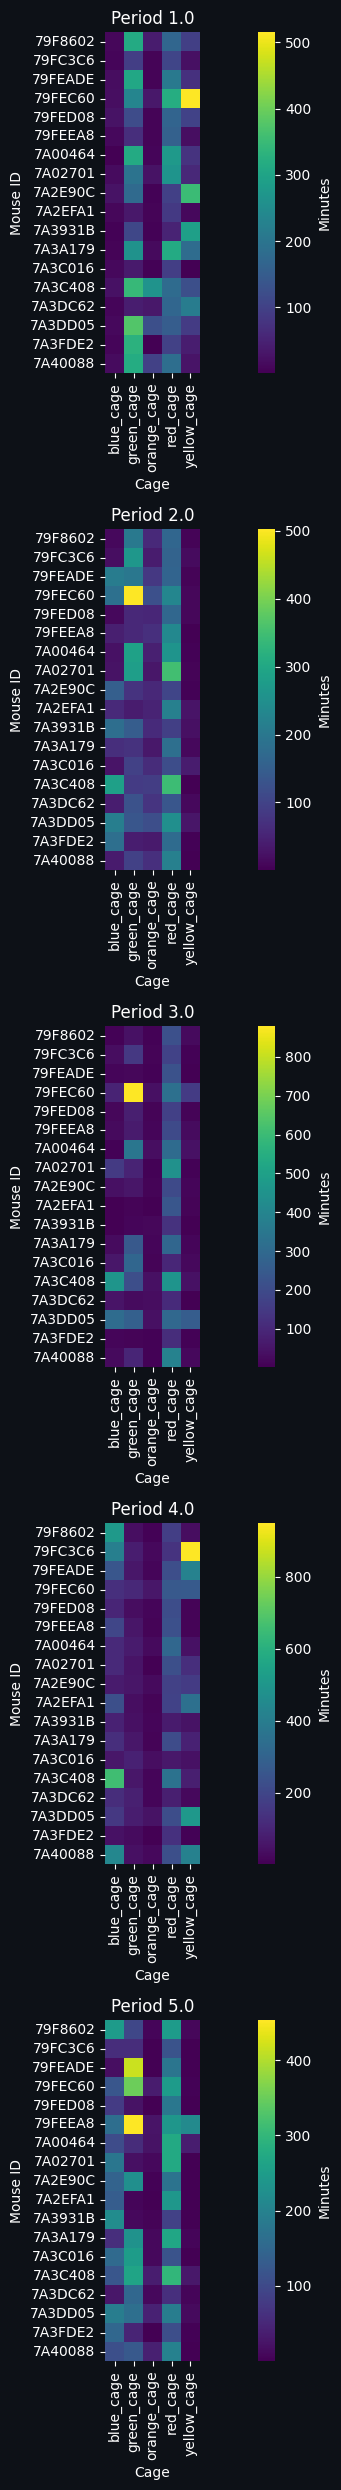

In [62]:
# Create vertically stacked heatmaps
n_periods = len(periods)
fig, axes = plt.subplots(n_periods, 1, figsize=(12, 5*n_periods))
plt.style.use('dark_background')

for idx, period in enumerate(sorted(periods)):
    period_data = results_df[results_df['Period'] == period]
    
    # Pivot data with mice on rows
    pivot_data = period_data.pivot(index='Mouse', columns='Cage', values='Time (min)')
    
    # Create heatmap with square cells and no annotations
    sns.heatmap(pivot_data, 
                ax=axes[idx],
                cmap='viridis',
                annot=False,
                square=True,  # Make cells square
                cbar_kws={'label': 'Minutes'})
    
    axes[idx].set_title(f'Period {period}')
    axes[idx].set_ylabel('Mouse ID')
    axes[idx].set_xlabel('Cage')

fig.patch.set_facecolor(BACKGROUND_COLOR)
plt.tight_layout()
plt.show()

In [63]:
# Save original data
results_df.to_parquet('../data/processed/rural/mouse_cage_time_raw.parquet')

# Create and save pivoted data for each period
pivot_data_dict = {}
for period in sorted(periods):
    period_data = results_df[results_df['Period'] == period]
    pivot_data = period_data.pivot(index='Mouse', columns='Cage', values='Time (min)')
    pivot_data_dict[period] = pivot_data
    
    # Save each period's pivot table separately
    pivot_data.to_parquet(f'../data/processed/rural/mouse_cage_time_period_{period}.parquet')

# Save all pivoted data in one file with period as additional index
all_pivot_data = pd.concat(pivot_data_dict, names=['Period'])
all_pivot_data.to_parquet('../data/processed/rural/mouse_cage_time_all_periods.parquet')

In [39]:
# Save individual mouse cage times
results_df.to_parquet('../data/processed/rural/mouse_cage_times.parquet')

# Save pivoted data for each mouse
pivot_data_all = {}
for mouse in mice:
    mouse_data = results_df[results_df['Mouse'] == mouse]
    pivot_data = mouse_data.pivot(index='Period', columns='Cage', values='Time (min)')
    pivot_data_all[mouse] = pivot_data

# Convert pivot_data_all to a single DataFrame with MultiIndex
pivot_df = pd.concat(pivot_data_all, names=['Mouse'])
pivot_df.to_parquet('../data/processed/rural/mouse_cage_times_pivoted.parquet')

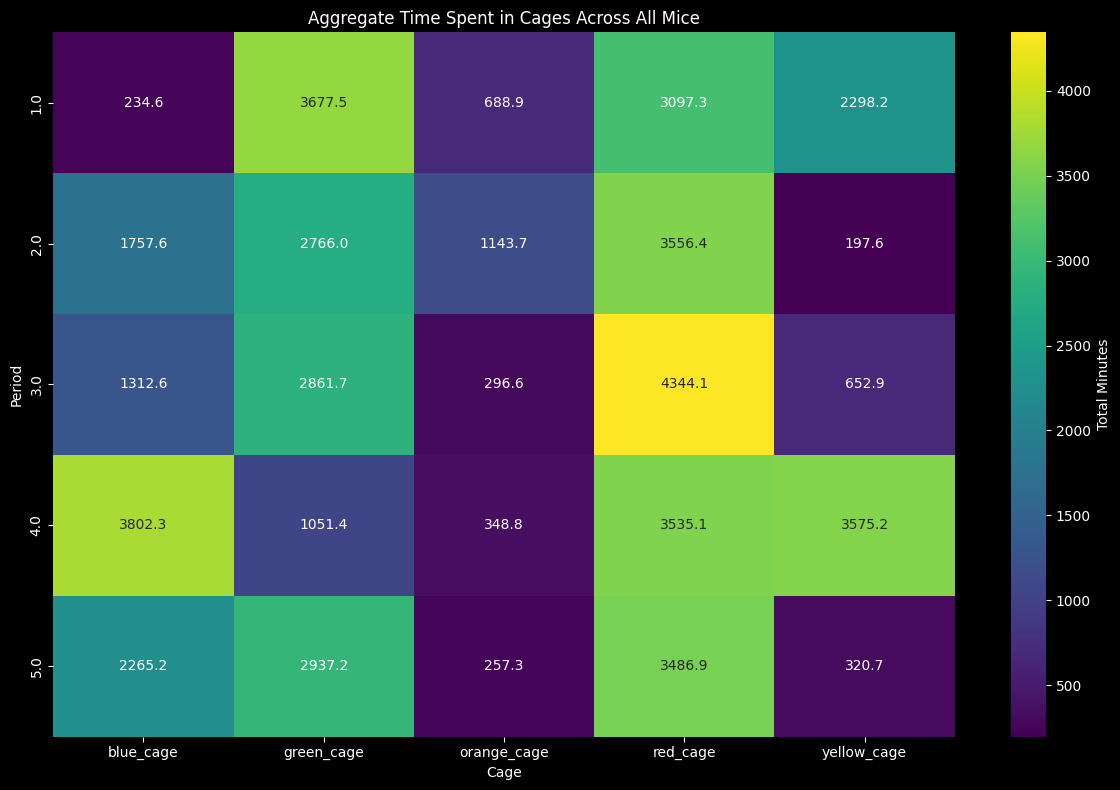

In [40]:
# Calculate aggregate time across all mice
agg_data = results_df.groupby(['Period', 'Cage'])['Time (min)'].sum().reset_index()
pivot_agg = agg_data.pivot(index='Period', columns='Cage', values='Time (min)')

# Create aggregate heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_agg, 
            cmap='viridis',
            annot=True,
            fmt='.1f',
            cbar_kws={'label': 'Total Minutes'})

plt.title('Aggregate Time Spent in Cages Across All Mice')
plt.ylabel('Period')
plt.xlabel('Cage')
plt.tight_layout()
plt.show()

In [41]:
# Save aggregated data
agg_data.to_parquet('../data/processed/rural/mouse_cage_times_aggregated.parquet')

# Save pivoted aggregated data
pivot_agg.to_parquet('../data/processed/rural/mouse_cage_times_aggregated_pivoted.parquet')

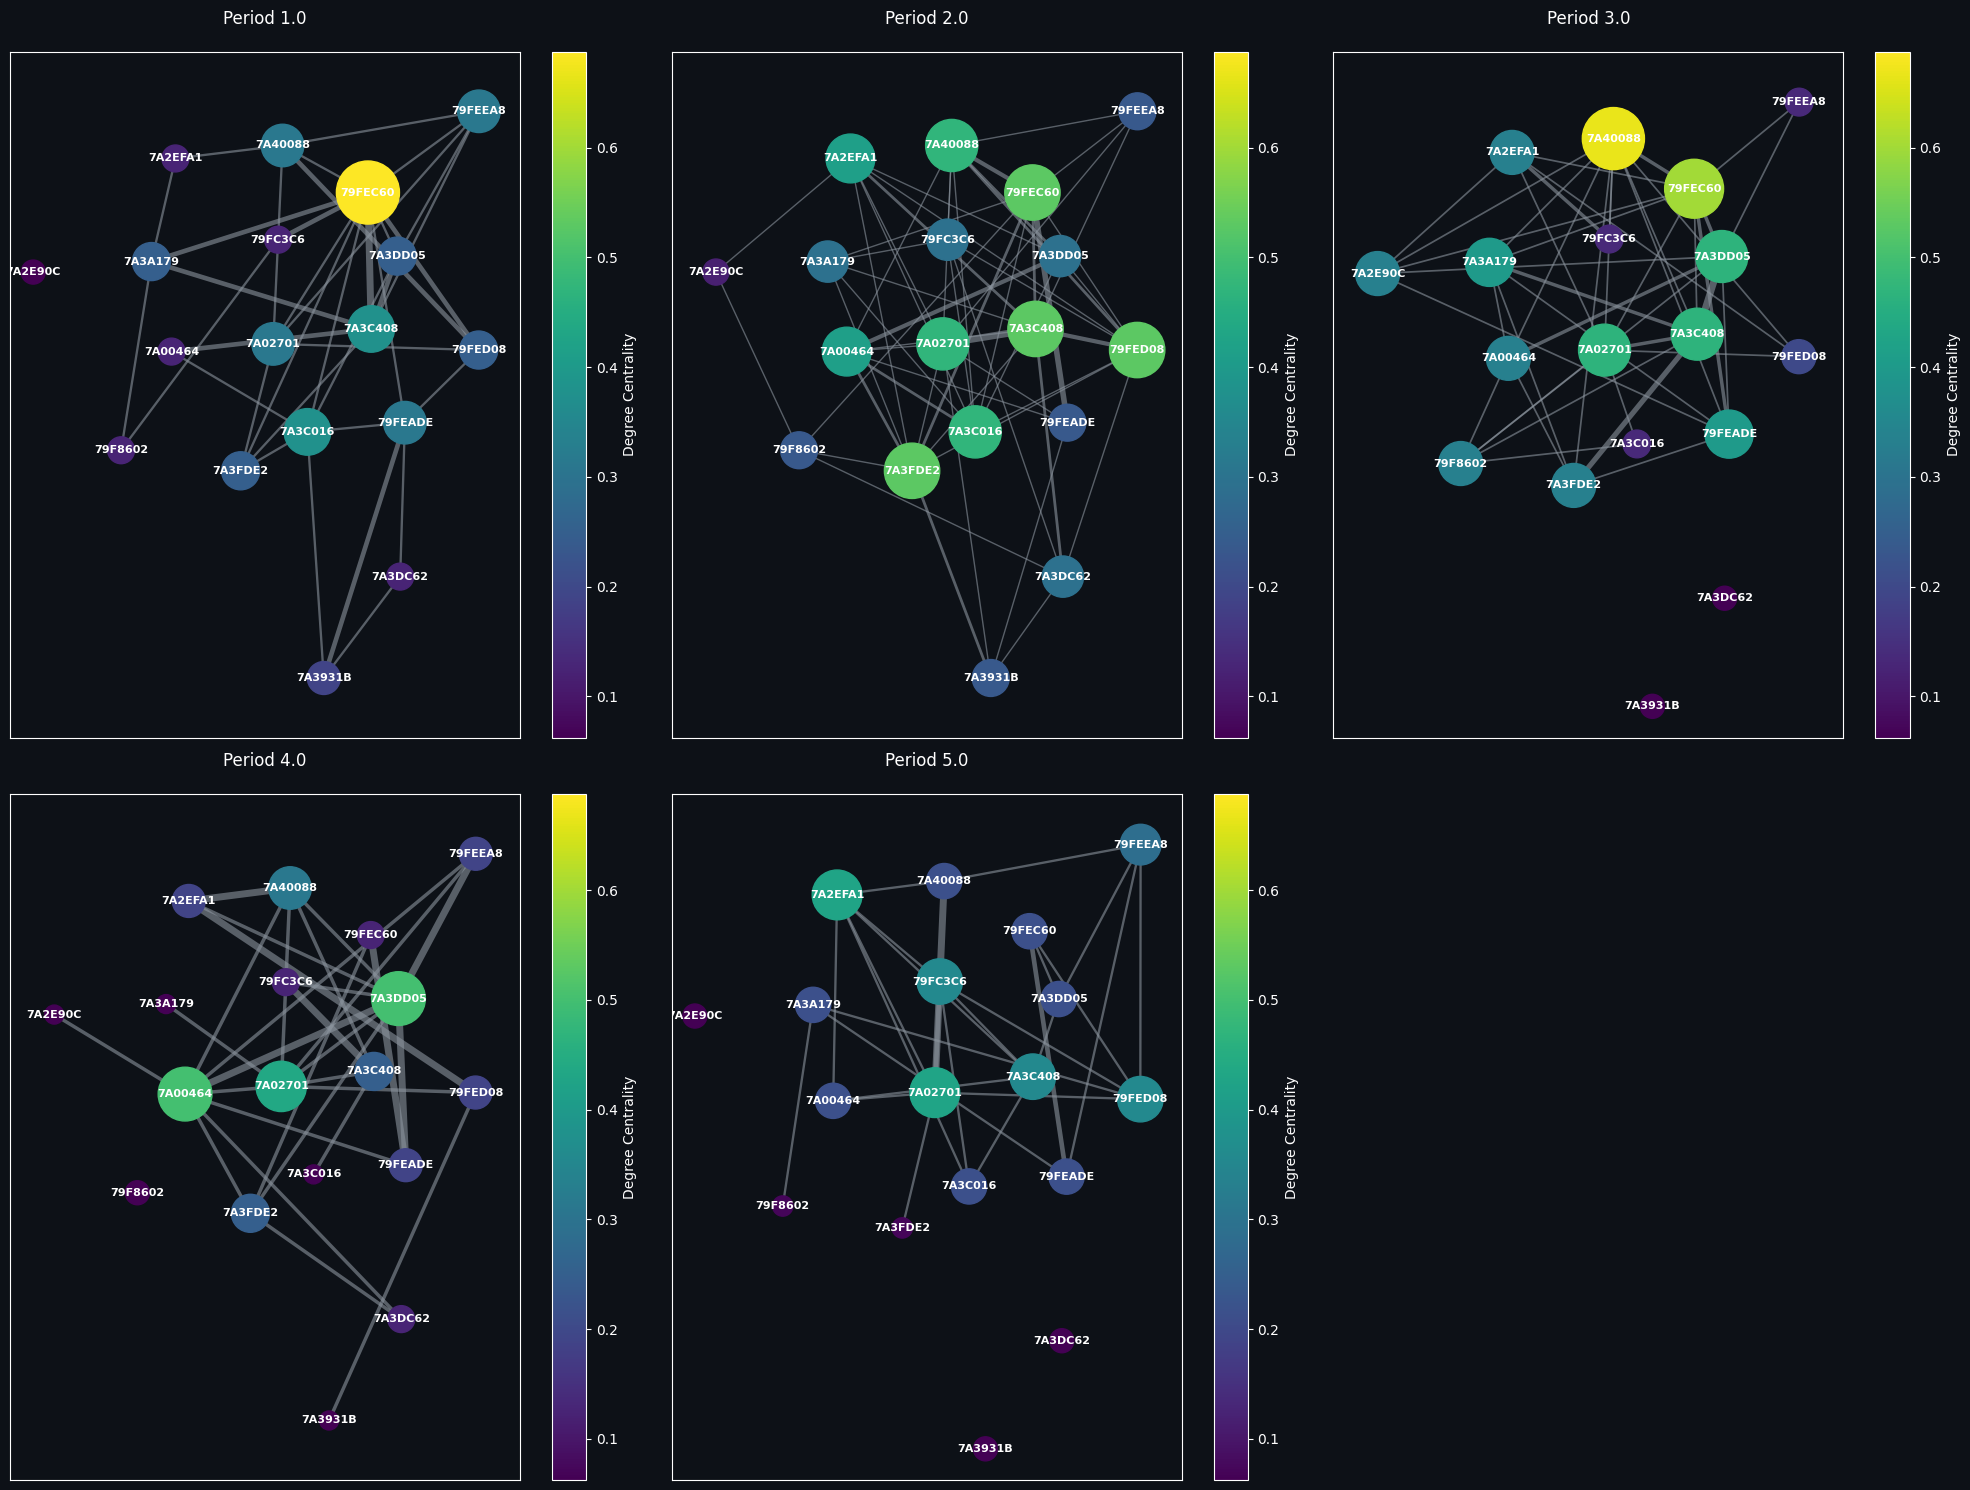

In [34]:
import networkx as nx
from itertools import combinations
import matplotlib.pyplot as plt
import pandas as pd

# GitHub Dark theme colors
BACKGROUND_COLOR = '#0d1117'
TEXT_COLOR = '#ffffff'  # Pure white for labels
EDGE_COLOR = '#8b949e'  # Light gray for edges

def get_overlapping_times(period_data):
    # Define cage locations
    cages = ['red_cage', 'orange_cage', 'yellow_cage', 'green_cage', 'blue_cage']
    
    # Initialize interaction counter
    interactions = {}
    mice = period_data['Transponder code'].unique()
    mouse_pairs = list(combinations(mice, 2))
    
    for pair in mouse_pairs:
        interactions[pair] = 0
    
    # Filter for cage locations only
    cage_data = period_data[period_data['Location'].isin(cages)]
    
    # Group by Time and Location to find co-occurrences
    time_location_groups = cage_data.groupby(['Time', 'Location'])
    
    # Check each time-location group for co-occurring mice
    for (time, location), group in time_location_groups:
        mice_present = group['Transponder code'].unique()
        
        # If more than one mouse present at this time and location
        if len(mice_present) > 1:
            # Count interactions for each pair
            for m1, m2 in combinations(mice_present, 2):
                if (m1, m2) in interactions:
                    interactions[(m1, m2)] += 1
                elif (m2, m1) in interactions:
                    interactions[(m2, m1)] += 1
    
    return interactions

# Create figure with dark theme
plt.style.use('dark_background')
fig, axes = plt.subplots(2, 3, figsize=(20, 15))
fig.patch.set_facecolor(BACKGROUND_COLOR)
axes = axes.flatten()

# Create a master graph for consistent layout
master_G = nx.Graph()
all_interactions = {}

# First pass to get all possible edges and calculate fixed positions
for period in periods:
    period_data = processed_df[processed_df['Period'] == period].copy()
    interactions = get_overlapping_times(period_data)
    
    for (m1, m2), weight in interactions.items():
        if weight > 0:
            master_G.add_edge(m1, m2)
            
# Calculate fixed positions
pos = nx.spring_layout(master_G, k=1, iterations=50)

# Calculate global min/max centrality for consistent color scaling
all_centralities = []
period_graphs = {}
for period in periods:
    period_data = processed_df[processed_df['Period'] == period].copy()
    interactions = get_overlapping_times(period_data)
    
    G = nx.Graph()
    for (m1, m2), weight in interactions.items():
        if weight > 0:
            G.add_edge(m1, m2, weight=weight)
    
    period_graphs[period] = G
    degree_cent = nx.degree_centrality(G)
    all_centralities.extend(list(degree_cent.values()))

vmin, vmax = min(all_centralities), max(all_centralities)

# Draw networks with consistent positions and color scaling
for period in periods:
    G = period_graphs[period]
    ax = axes[int(period)-1]
    ax.set_facecolor(BACKGROUND_COLOR)
    
    # Calculate centrality for this period
    degree_cent = nx.degree_centrality(G)
    centrality_values = [degree_cent.get(node, 0) for node in master_G.nodes()]
    
    # Draw edges
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
    if edge_weights:
        max_weight = max(edge_weights)
        nx.draw_networkx_edges(G, pos, ax=ax,
                             edge_color=EDGE_COLOR,
                             width=[w/max_weight*5 for w in edge_weights],
                             alpha=0.6)
    
    # Draw nodes for all possible mice
    nodes = nx.draw_networkx_nodes(master_G, pos, ax=ax,
                                 node_size=[3000 * degree_cent.get(node, 0.1) for node in master_G.nodes()],
                                 node_color=[degree_cent.get(node, 0) for node in master_G.nodes()],
                                 cmap='viridis',
                                 vmin=vmin,
                                 vmax=vmax)
    
    # Add labels with bright white color
    nx.draw_networkx_labels(master_G, pos, ax=ax,
                           font_size=8,
                           font_color=TEXT_COLOR,
                           font_weight='bold')
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap='viridis', 
                              norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Degree Centrality', color=TEXT_COLOR)
    cbar.ax.yaxis.set_tick_params(color=TEXT_COLOR)
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color=TEXT_COLOR)
    
    ax.set_title(f'Period {period}', color=TEXT_COLOR, pad=20)
    ax.set_xticks([])
    ax.set_yticks([])

# Remove extra subplot
axes[-1].remove()

plt.tight_layout()
plt.show()

In [35]:
# After generating all the graphs but before plt.show(), add:

# Prepare data for saving
graph_data = []

for period in periods:
    G = period_graphs[period]
    degree_cent = nx.degree_centrality(G)
    
    # Get edge data
    for (m1, m2), weight in nx.get_edge_attributes(G, 'weight').items():
        graph_data.append({
            'period': period,
            'mouse1': m1,
            'mouse2': m2,
            'interaction_count': weight,
            'mouse1_centrality': degree_cent.get(m1, 0),
            'mouse2_centrality': degree_cent.get(m2, 0)
        })

# Convert to DataFrame
graph_df = pd.DataFrame(graph_data)

# Save to parquet
graph_df.to_parquet('../data/processed/rural/mouse_interactions.parquet')

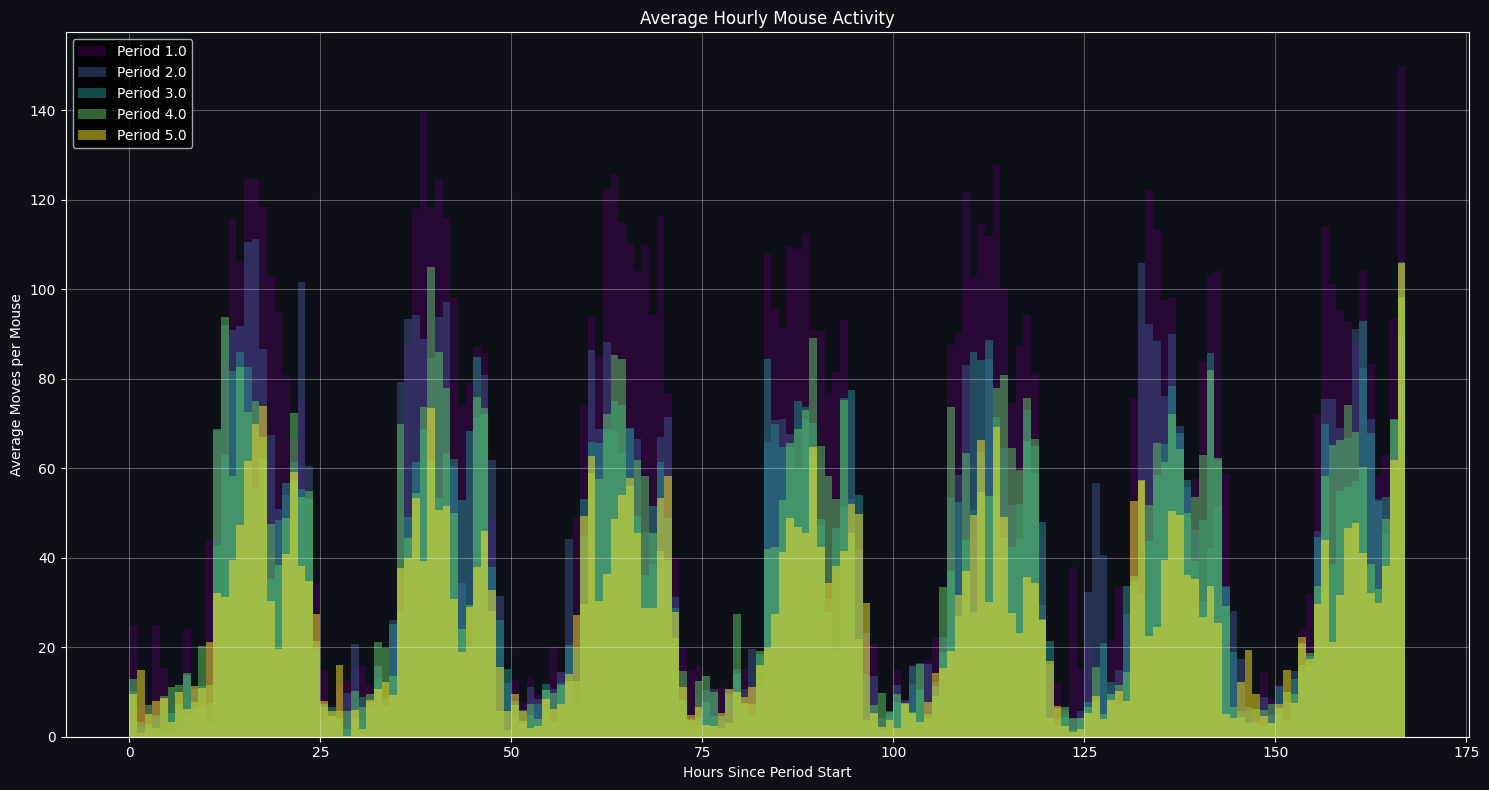

In [45]:
# Process data to get hourly activity counts
def get_hourly_activity(df):
    df = df.copy()
    df['Hour'] = df['Time'].dt.floor('h')
    
    # Count unit number changes per hour
    activity_counts = (
        df.groupby(['Hour', 'Transponder code', 'Period'])
        .agg(Moves=('Unit number', lambda x: (x != x.shift()).sum()))
        .reset_index()
    )
    
    return activity_counts

# Get activity data and calculate average per mouse
activity_data = get_hourly_activity(processed_df)
n_mice = len(processed_df['Transponder code'].unique())

# Calculate average moves per mouse
agg_activity = (
    activity_data.groupby(['Hour', 'Period'])
    .agg(Avg_Moves=('Moves', lambda x: x.sum() / n_mice))
    .reset_index()
)

# Create histogram
plt.figure(figsize=(15, 8))
plt.style.use('dark_background')

# Plot each period
colors = plt.cm.viridis(np.linspace(0, 1, len(processed_df['Period'].unique())))
for period, color in zip(sorted(processed_df['Period'].unique()), colors):
    period_data = agg_activity[agg_activity['Period'] == period].copy()
    period_data.loc[:, 'Hours'] = (
        (period_data['Hour'] - period_data['Hour'].min()).dt.total_seconds() / 3600
    )
    
    # Calculate bin edges for exact 1-hour width
    max_hours = period_data['Hours'].max()
    bins = np.arange(0, max_hours + 1, 1)  # 1-hour width
    
    plt.hist(period_data['Hours'], 
            weights=period_data['Avg_Moves'],
            bins=bins,
            alpha=0.5,
            color=color,
            label=f'Period {period}',
            histtype='bar',
            rwidth=1.0)  # Full width bars

plt.title('Average Hourly Mouse Activity')
plt.xlabel('Hours Since Period Start')
plt.ylabel('Average Moves per Mouse')
plt.grid(True, alpha=0.3)
plt.gca().set_facecolor(BACKGROUND_COLOR)
plt.gcf().set_facecolor(BACKGROUND_COLOR)
plt.legend()
plt.tight_layout()
plt.show()

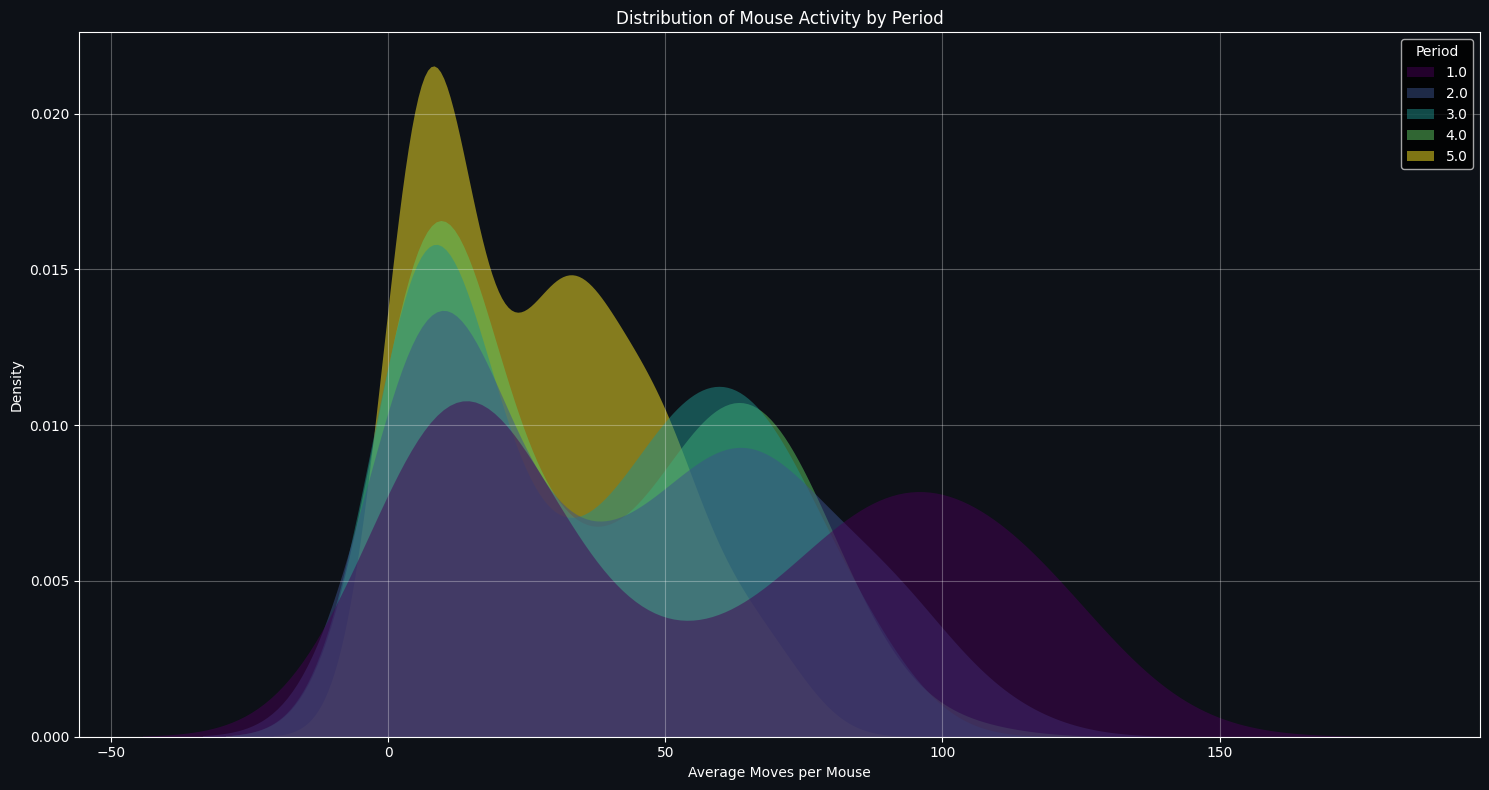

In [49]:
# Process data to get hourly activity counts
def get_hourly_activity(df):
    df = df.copy()
    df['Hour'] = df['Time'].dt.floor('h')
    
    # Count unit number changes per hour
    activity_counts = (
        df.groupby(['Hour', 'Transponder code', 'Period'])
        .agg(Moves=('Unit number', lambda x: (x != x.shift()).sum()))
        .reset_index()
    )
    
    return activity_counts

# Get activity data and calculate average per mouse
activity_data = get_hourly_activity(processed_df)
n_mice = len(processed_df['Transponder code'].unique())

# Calculate average moves per mouse
agg_activity = (
    activity_data.groupby(['Hour', 'Period'])
    .agg(Avg_Moves=('Moves', lambda x: x.sum() / n_mice))
    .reset_index()
)

# Calculate hours for all periods without using groupby.apply
period_starts = agg_activity.groupby('Period')['Hour'].transform('min')
agg_activity['Hours'] = (agg_activity['Hour'] - period_starts).dt.total_seconds() / 3600

# Create univariate KDE plot
plt.figure(figsize=(15, 8))
plt.style.use('dark_background')

sns.kdeplot(
    data=agg_activity,
    x='Avg_Moves',
    hue='Period',
    fill=True,
    common_norm=False,
    palette='viridis',
    alpha=0.5,
    linewidth=0
)

plt.title('Distribution of Mouse Activity by Period')
plt.xlabel('Average Moves per Mouse')
plt.ylabel('Density')
plt.grid(True, alpha=0.3)
plt.gca().set_facecolor(BACKGROUND_COLOR)
plt.gcf().set_facecolor(BACKGROUND_COLOR)
plt.tight_layout()
plt.show()

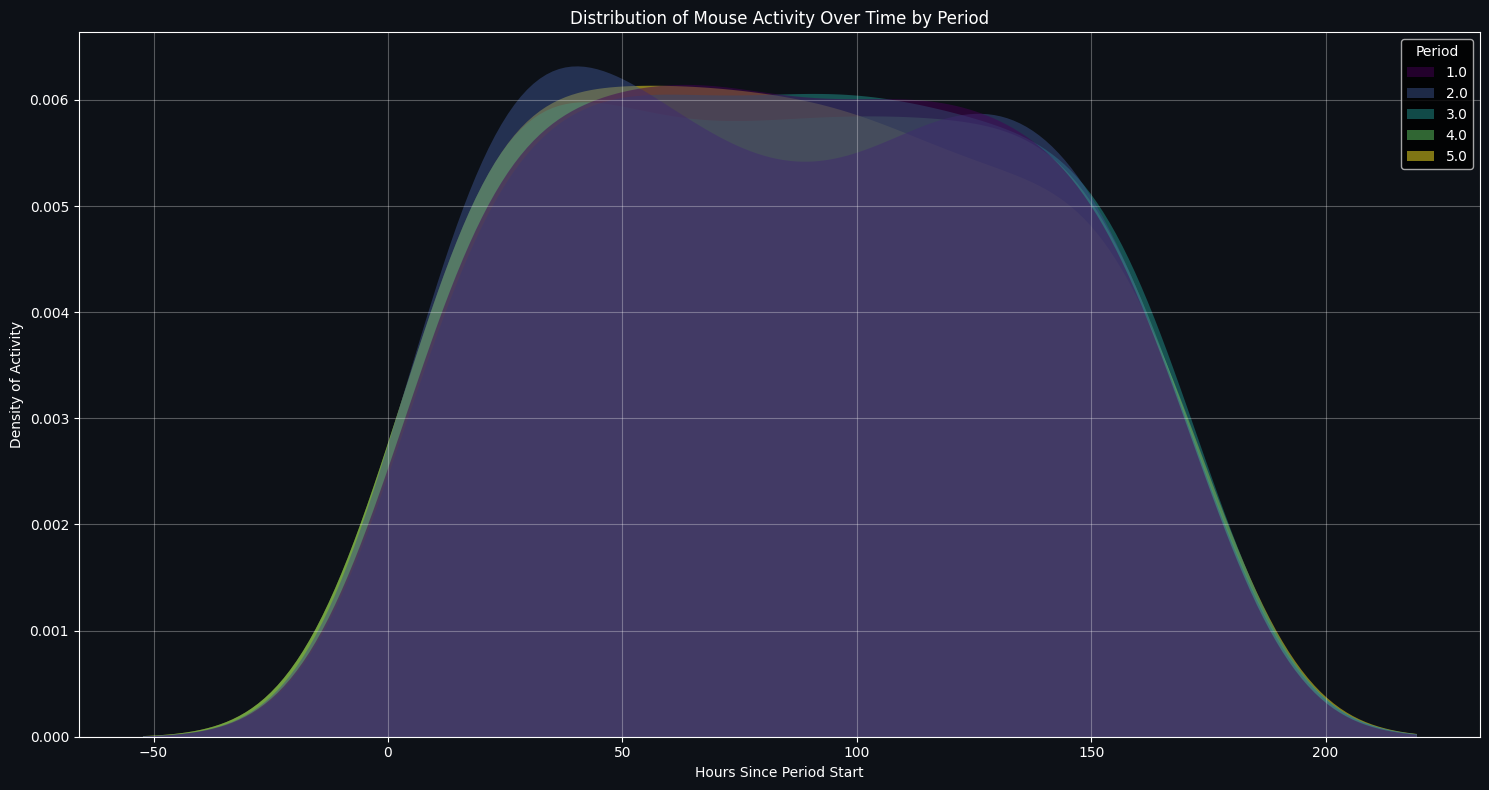

In [50]:
# Process data to get hourly activity counts
def get_hourly_activity(df):
    df = df.copy()
    df['Hour'] = df['Time'].dt.floor('h')
    
    # Count unit number changes per hour
    activity_counts = (
        df.groupby(['Hour', 'Transponder code', 'Period'])
        .agg(Moves=('Unit number', lambda x: (x != x.shift()).sum()))
        .reset_index()
    )
    
    return activity_counts

# Get activity data and calculate average per mouse
activity_data = get_hourly_activity(processed_df)
n_mice = len(processed_df['Transponder code'].unique())

# Calculate average moves per mouse
agg_activity = (
    activity_data.groupby(['Hour', 'Period'])
    .agg(Avg_Moves=('Moves', lambda x: x.sum() / n_mice))
    .reset_index()
)

# Calculate hours for all periods without using groupby.apply
period_starts = agg_activity.groupby('Period')['Hour'].transform('min')
agg_activity['Hours'] = (agg_activity['Hour'] - period_starts).dt.total_seconds() / 3600

# Create univariate KDE plot
plt.figure(figsize=(15, 8))
plt.style.use('dark_background')

sns.kdeplot(
    data=agg_activity,
    x='Hours',
    weights='Avg_Moves',
    hue='Period',
    fill=True,
    common_norm=False,
    palette='viridis',
    alpha=0.5,
    linewidth=0
)

plt.title('Distribution of Mouse Activity Over Time by Period')
plt.xlabel('Hours Since Period Start')
plt.ylabel('Density of Activity')
plt.grid(True, alpha=0.3)
plt.gca().set_facecolor(BACKGROUND_COLOR)
plt.gcf().set_facecolor(BACKGROUND_COLOR)
plt.tight_layout()
plt.show()

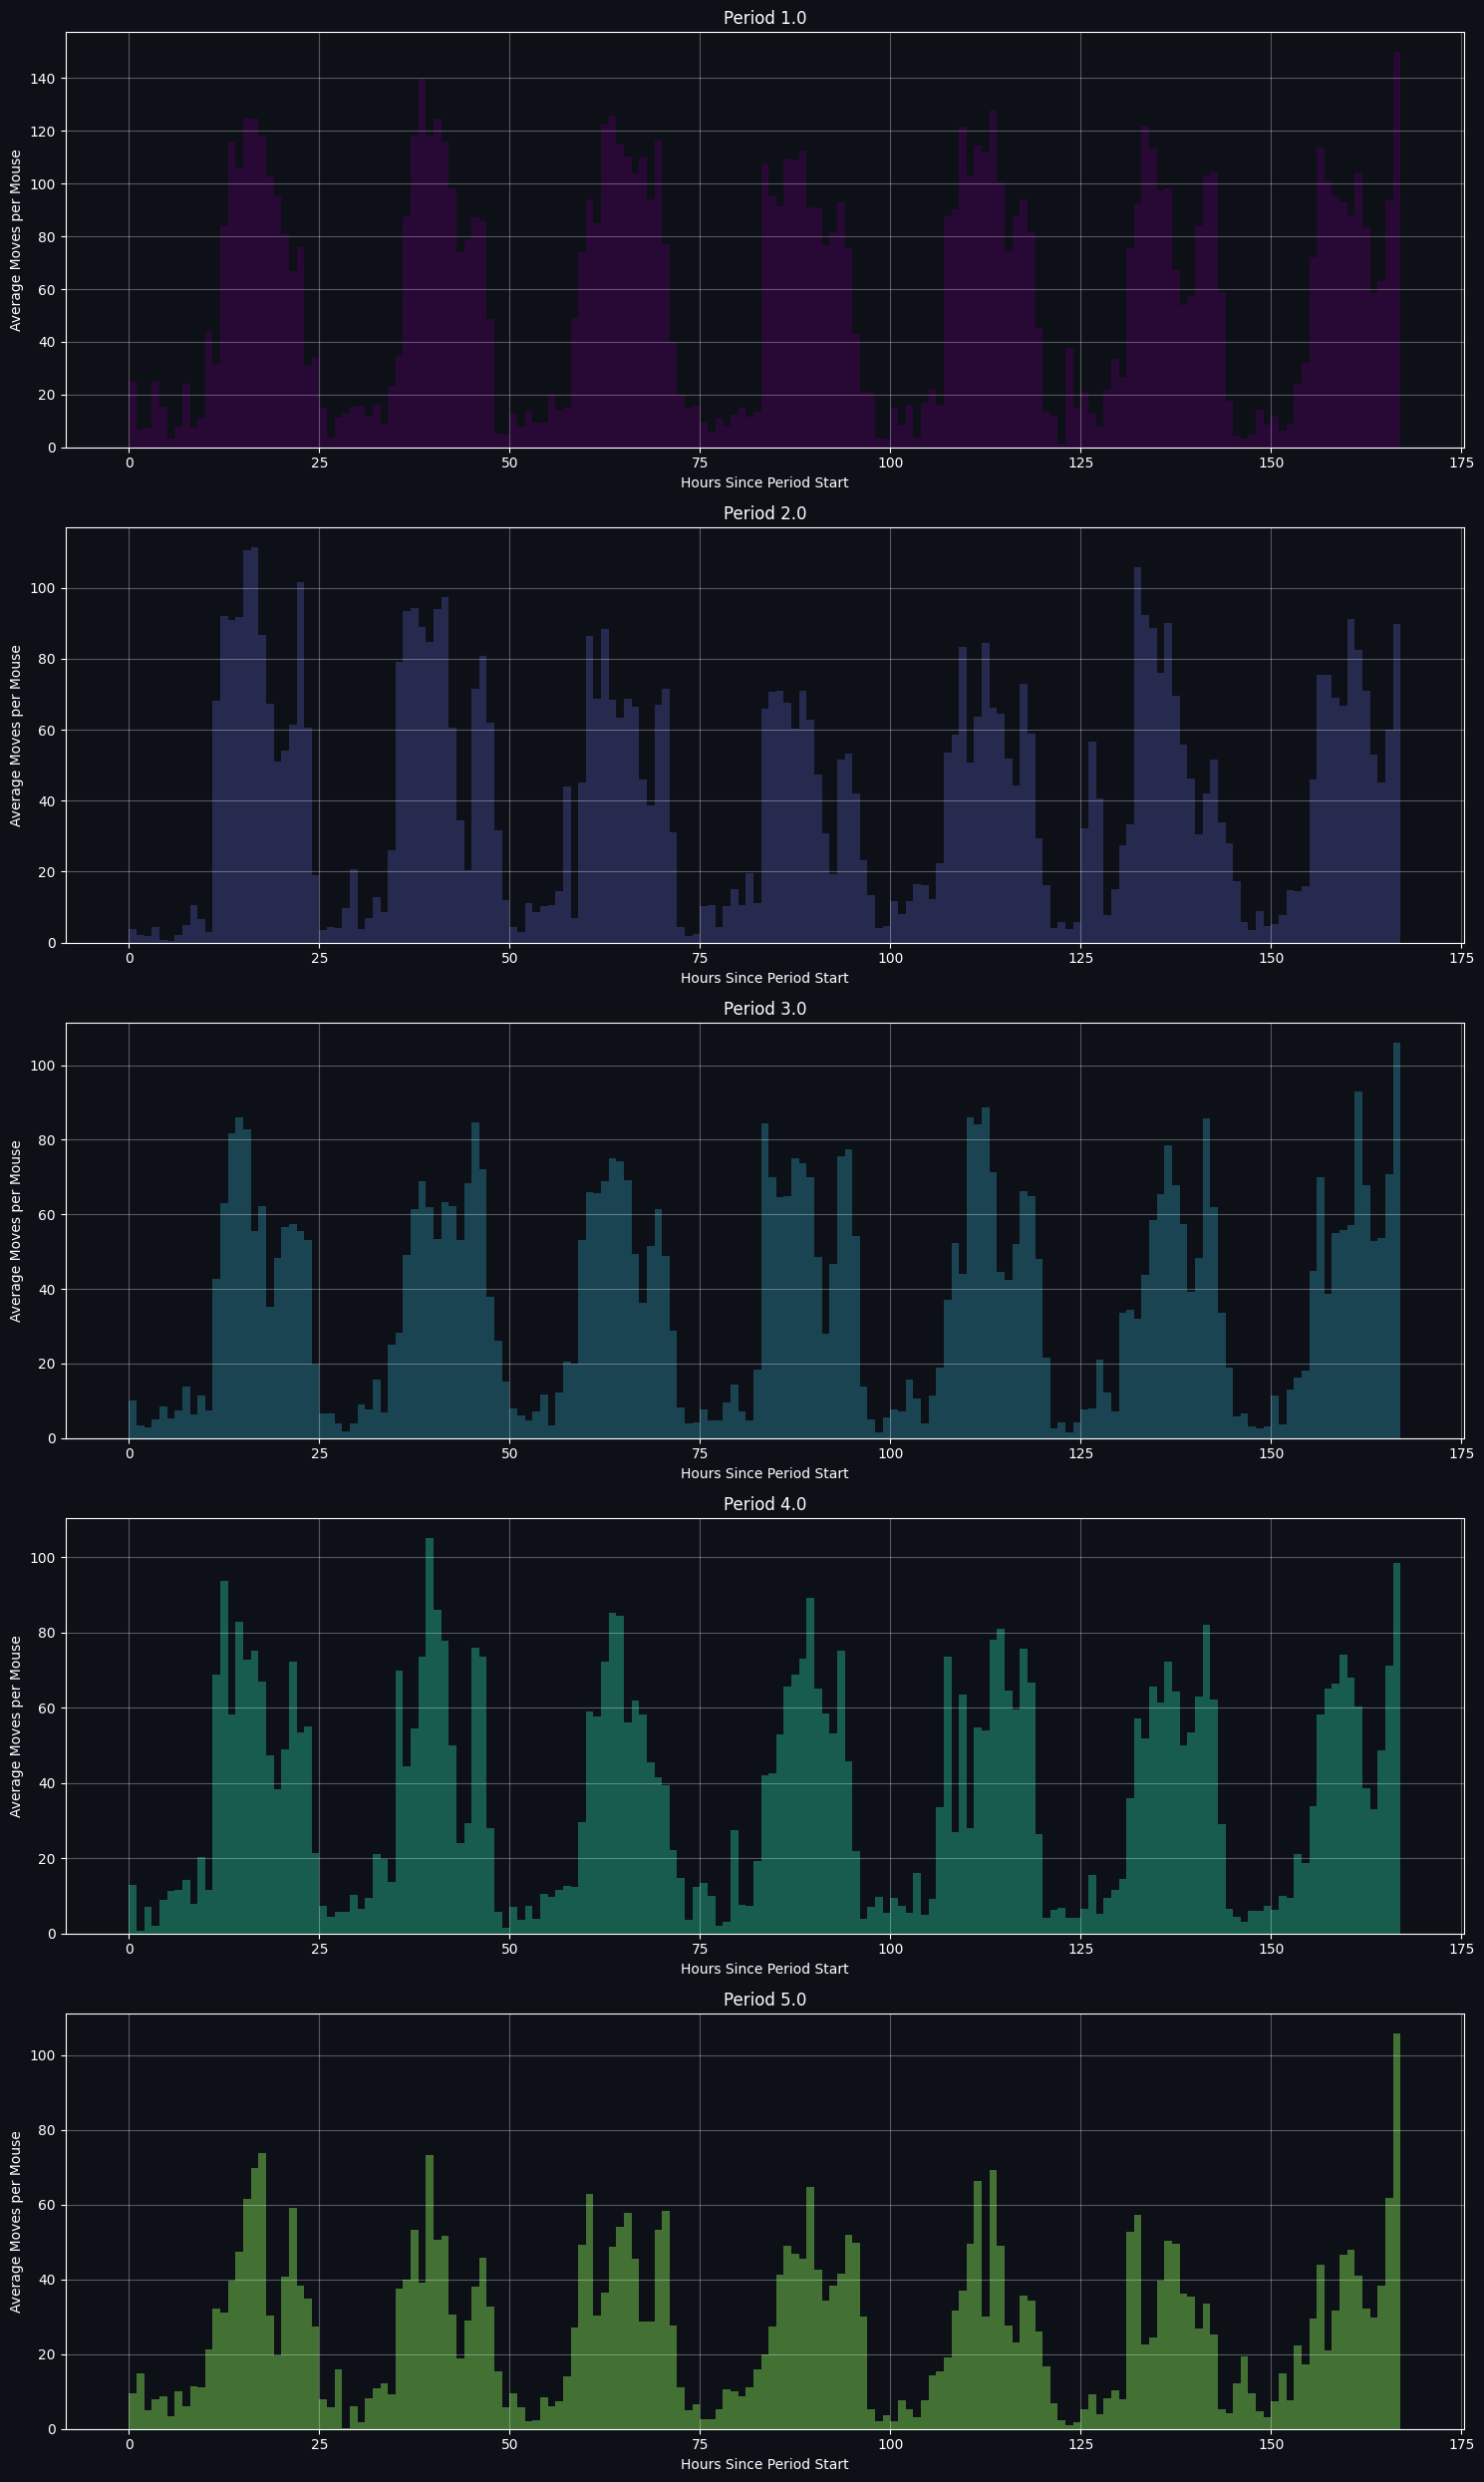

In [56]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Process data to get hourly activity counts
def get_hourly_activity(df):
    df = df.copy()
    df['Hour'] = df['Time'].dt.floor('h')
    
    # Count unit number changes per hour
    activity_counts = (
        df.groupby(['Hour', 'Transponder code', 'Period'])
        .agg(Moves=('Unit number', lambda x: (x != x.shift()).sum()))
        .reset_index()
    )
    
    return activity_counts

# GitHub Dark theme colors
BACKGROUND_COLOR = '#0d1117'

# Get activity data and calculate average per mouse
activity_data = get_hourly_activity(processed_df)
n_mice = len(processed_df['Transponder code'].unique())

# Calculate average moves per mouse
agg_activity = (
    activity_data.groupby(['Hour', 'Period'])
    .agg(Avg_Moves=('Moves', lambda x: x.sum() / n_mice))
    .reset_index()
)

# Calculate hours for all periods
period_starts = agg_activity.groupby('Period')['Hour'].transform('min')
agg_activity['Hours'] = (agg_activity['Hour'] - period_starts).dt.total_seconds() / 3600

# Save processed data
agg_activity.to_parquet('../data/processed/rural/mouse_activity_histogram.parquet')

# Create vertically stacked histograms
n_periods = len(agg_activity['Period'].unique())
fig, axes = plt.subplots(n_periods, 1, figsize=(15, 5*n_periods))
plt.style.use('dark_background')

for idx, period in enumerate(sorted(agg_activity['Period'].unique())):
    period_data = agg_activity[agg_activity['Period'] == period]
    
    sns.histplot(
        data=period_data,
        x='Hours',
        weights='Avg_Moves',
        ax=axes[idx],
        color=plt.cm.viridis(idx/n_periods),
        alpha=0.5,
        binwidth=1,  # Use only binwidth for 1-hour intervals
        stat='count',  # Use count instead of density
        edgecolor=None,  # Remove borders
        linewidth=0  # Remove lines between bars
    )
    
    axes[idx].set_title(f'Period {period}')
    axes[idx].set_xlabel('Hours Since Period Start')
    axes[idx].set_ylabel('Average Moves per Mouse')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_facecolor(BACKGROUND_COLOR)

fig.patch.set_facecolor(BACKGROUND_COLOR)
plt.tight_layout()
plt.show()

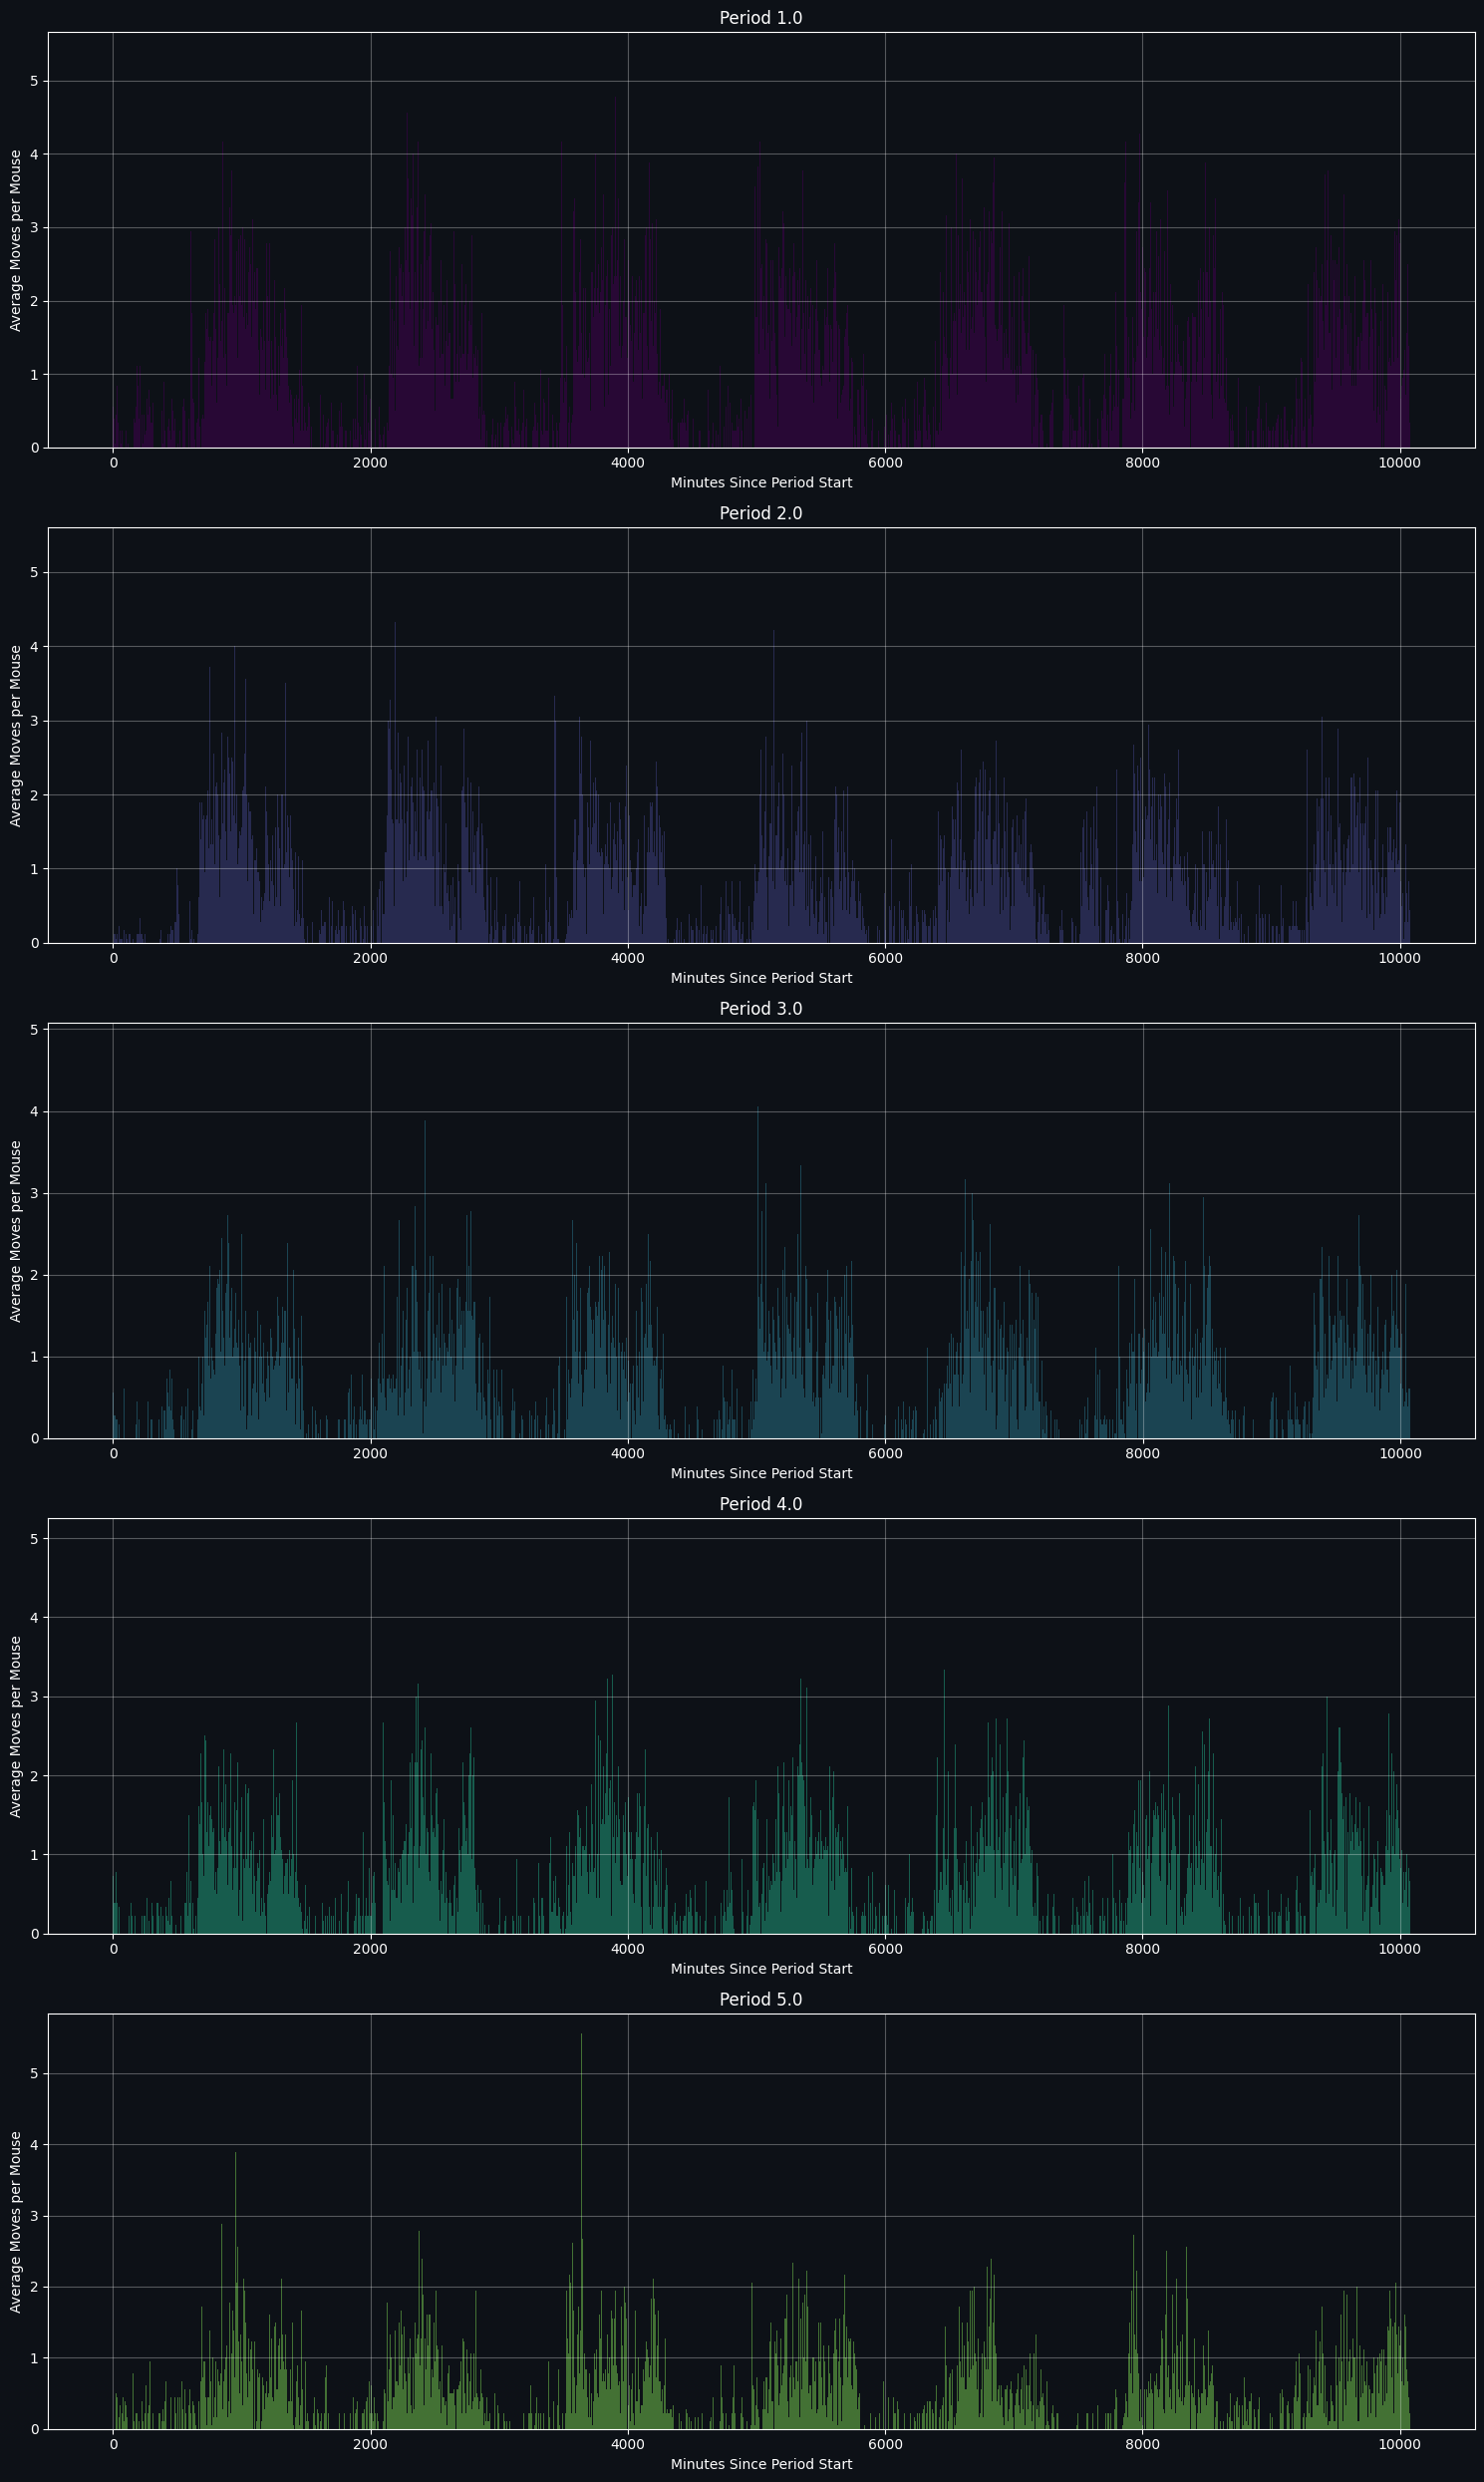

In [57]:
# Process data to get minute activity counts
def get_minute_activity(df):
    df = df.copy()
    df['Minute'] = df['Time'].dt.floor('min')
    
    # Count unit number changes per minute
    activity_counts = (
        df.groupby(['Minute', 'Transponder code', 'Period'])
        .agg(Moves=('Unit number', lambda x: (x != x.shift()).sum()))
        .reset_index()
    )
    
    return activity_counts

# Get activity data and calculate average per mouse
activity_data = get_minute_activity(processed_df)
n_mice = len(processed_df['Transponder code'].unique())

# Calculate average moves per mouse
agg_activity = (
    activity_data.groupby(['Minute', 'Period'])
    .agg(Avg_Moves=('Moves', lambda x: x.sum() / n_mice))
    .reset_index()
)

# Calculate minutes for all periods
period_starts = agg_activity.groupby('Period')['Minute'].transform('min')
agg_activity['Minutes'] = (agg_activity['Minute'] - period_starts).dt.total_seconds() / 60

# Save processed data
agg_activity.to_parquet('../data/processed/rural/mouse_activity_minute_histogram.parquet')

# Create vertically stacked histograms
n_periods = len(agg_activity['Period'].unique())
fig, axes = plt.subplots(n_periods, 1, figsize=(15, 5*n_periods))
plt.style.use('dark_background')

for idx, period in enumerate(sorted(agg_activity['Period'].unique())):
    period_data = agg_activity[agg_activity['Period'] == period]
    
    sns.histplot(
        data=period_data,
        x='Minutes',
        weights='Avg_Moves',
        ax=axes[idx],
        color=plt.cm.viridis(idx/n_periods),
        alpha=0.5,
        binwidth=1,  # Use 1-minute width
        stat='count',  # Use count instead of density
        edgecolor=None,  # Remove borders
        linewidth=0  # Remove lines between bars
    )
    
    axes[idx].set_title(f'Period {period}')
    axes[idx].set_xlabel('Minutes Since Period Start')
    axes[idx].set_ylabel('Average Moves per Mouse')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_facecolor(BACKGROUND_COLOR)

fig.patch.set_facecolor(BACKGROUND_COLOR)
plt.tight_layout()
plt.show()